Link: https://tinyurl.com/pqtsolutions3

# Workshop 3: Advanced Regressions

Welcome to this introductory workshop on quantitative finance! In this workshop, we'll explore:

1. **Review of Linear Regression** - How to predict a stock's return from other stock returns
2. **Rolling Regression** -- Making your regressions account for the recent past
3. **Regularization** -- L1 and L2 regularizers
4. **Feature Engineering** -- Constructing EWMA features and making features uncorrelated
5. **Statistical Testing** -- Validating our signals with t-statistics
6. **Signal to Trades** - Converting predictions into actual trading decisions

We'll focus on a set of stocks and try to predict the price movement at a given time from the price movements of the other stocks in the past.

## 1: Load the Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jacksoncrow/stock-market-dataset")

print("Path to dataset files:", path)

/home/de7281/pqt-workshops/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/de7281/.cache/kagglehub/datasets/jacksoncrow/stock-market-dataset/versions/2


## 2: Extract the Relevant Stocks

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# List all stocks under the 'stocks' directory
import os
stocks_dir = os.path.join(path, 'stocks')
all_stocks = [f for f in os.listdir(stocks_dir) if f.endswith('.csv')]
print("Available stocks:", all_stocks)

Available stocks: ['A.csv', 'AA.csv', 'AACG.csv', 'AAL.csv', 'AAMC.csv', 'AAME.csv', 'AAN.csv', 'AAOI.csv', 'AAON.csv', 'AAP.csv', 'AAPL.csv', 'AAT.csv', 'AAU.csv', 'AAWW.csv', 'AAXN.csv', 'AB.csv', 'ABB.csv', 'ABBV.csv', 'ABC.csv', 'ABCB.csv', 'ABEO.csv', 'ABEV.csv', 'ABG.csv', 'ABIO.csv', 'ABM.csv', 'ABMD.csv', 'ABR.csv', 'ABT.csv', 'ABTX.csv', 'ABUS.csv', 'AC.csv', 'ACA.csv', 'ACAD.csv', 'ACAM.csv', 'ACAMU.csv', 'ACB.csv', 'ACBI.csv', 'ACC.csv', 'ACCO.csv', 'ACEL.csv', 'ACER.csv', 'ACGL.csv', 'ACGLO.csv', 'ACGLP.csv', 'ACH.csv', 'ACHC.csv', 'ACHV.csv', 'ACIA.csv', 'ACIU.csv', 'ACIW.csv', 'ACLS.csv', 'ACM.csv', 'ACMR.csv', 'ACN.csv', 'ACNB.csv', 'ACOR.csv', 'ACP.csv', 'ACRE.csv', 'ACRS.csv', 'ACRX.csv', 'ACST.csv', 'ACTG.csv', 'ACTT.csv', 'ACTTU.csv', 'ACU.csv', 'ACV.csv', 'ACY.csv', 'ADAP.csv', 'ADBE.csv', 'ADC.csv', 'ADES.csv', 'ADI.csv', 'ADIL.csv', 'ADM.csv', 'ADMA.csv', 'ADMP.csv', 'ADMS.csv', 'ADNT.csv', 'ADP.csv', 'ADPT.csv', 'ADRO.csv', 'ADS.csv', 'ADSK.csv', 'ADSW.csv', 'ADT

In [ ]:
# Choose all available stocks except AAPL as predictors
predictors = [f.replace('.csv', '') for f in all_stocks if f.replace('.csv', '') != 'AAPL']
responder = 'AAPL'

In [ ]:
stock_paths = {stock: os.path.join(stocks_dir, f"{stock}.csv") for stock in predictors + [responder]}
# Load all stock data
stock_data = {stock: pd.read_csv(stock_paths[stock]) for stock in stock_paths}

In [ ]:
d1 = stock_data['FB']
d2 = stock_data['AAPL']
merged = pd.merge(d1, d2, on='Date', how='inner', suffixes=('_FB', '_AAPL'))
print(merged.head())
print(merged.columns)
print(merged['Close_FB'].pct_change().corr(merged['Close_AAPL'].pct_change()))


         Date    Open_FB    High_FB     Low_FB   Close_FB  Adj Close_FB  \
0  2012-05-18  42.049999  45.000000  38.000000  38.230000     38.230000   
1  2012-05-21  36.529999  36.660000  33.000000  34.029999     34.029999   
2  2012-05-22  32.610001  33.590000  30.940001  31.000000     31.000000   
3  2012-05-23  31.370001  32.500000  31.360001  32.000000     32.000000   
4  2012-05-24  32.950001  33.209999  31.770000  33.029999     33.029999   

   Volume_FB  Open_AAPL  High_AAPL   Low_AAPL  Close_AAPL  Adj Close_AAPL  \
0  573576400  76.279999  77.629997  74.597145   75.768570       65.770210   
1  168192700  76.357140  80.220001  76.292854   80.182854       69.601997   
2  101786600  81.364288  81.982857  78.940002   79.567146       69.067520   
3   73600000  79.642860  81.828575  79.032860   81.508568       70.752777   
4   50237200  82.267143  82.357140  80.175713   80.760002       70.102989   

   Volume_AAPL  
0    183073100  
1    157776500  
2    173717600  
3    146224400  
4

In [ ]:
#stock is good if it has more than 1000 rows and significant correlation with AAPL (>0.1 or <-0.1)
def is_good(stock):
    data = stock_data[stock]
    # merge dataframes, calculate correlation of returns
    merged = pd.merge(data, stock_data[responder], on='Date', how='inner', suffixes=(f'_{stock}', f'_{responder}'))
    if len(merged) < 1000:
        return False
    corr = merged[f'Close_{stock}'].pct_change().corr(merged[f'Close_{responder}'].pct_change())
    return abs(corr) > 0.3

In [ ]:
good_predictors = [stock for stock in predictors if is_good(stock)]
print("Good predictors:", good_predictors)

/tmp/ipykernel_645052/1897195885.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  corr = merged[f'Close_{stock}'].pct_change().corr(merged[f'Close_{responder}'].pct_change())
/home/de7281/pqt-workshops/.venv/lib64/python3.9/site-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/de7281/pqt-workshops/.venv/lib64/python3.9/site-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/de7281/pqt-workshops/.venv/lib64/python3.9/site-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/tmp/ipykernel_645052/1897195885.py:8: FutureWarning: The default fill_method='pad' in Series.p

Good predictors: ['A', 'AAL', 'AAT', 'AAWW', 'ABB', 'ABBV', 'ABTX', 'ACBI', 'ACC', 'ACH', 'ACM', 'ACN', 'ACV', 'ADBE', 'ADI', 'ADSK', 'AEIS', 'AEL', 'AER', 'AGD', 'AGNC', 'AGO', 'AHH', 'AIF', 'AIMC', 'AINV', 'AIZ', 'AKAM', 'AL', 'ALLE', 'ALLY', 'ALRM', 'ALSN', 'AMAT', 'AMBA', 'AMD', 'AMG', 'AMH', 'AMJ', 'AMKR', 'AMOV', 'AMP', 'AMU', 'AMX', 'AMZN', 'ANET', 'AOD', 'APAM', 'APLE', 'APO', 'APPF', 'APTV', 'AQN', 'ARCC', 'ARES', 'AROC', 'ASML', 'ATMP', 'AVAL', 'AVGO', 'AVK', 'AVNS', 'AVT', 'AWI', 'AWP', 'AXP', 'AXS', 'AXTA', 'AYI', 'BABA', 'BB', 'BBD', 'BBL', 'BCC', 'BCX', 'BDCS', 'BDJ', 'BECN', 'BFAM', 'BFIN', 'BGH', 'BGR', 'BGY', 'BIDU', 'BIP', 'BKCC', 'BKU', 'BLDR', 'BLK', 'BLKB', 'BMCH', 'BME', 'BOE', 'BOX', 'BPMC', 'BPY', 'BR', 'BRKS', 'BRX', 'BSBR', 'BSIG', 'BTZ', 'BUD', 'BURL', 'BWXT', 'BX', 'BXMX', 'CABO', 'CAF', 'CAPE', 'CARO', 'CBRE', 'CCMP', 'CCS', 'CDK', 'CDW', 'CE', 'CEO', 'CF', 'CFG', 'CFX', 'CG', 'CGO', 'CHA', 'CHCT', 'CHI', 'CHL', 'CHT', 'CHTR', 'CHU', 'CHW', 'CHY', 'CII', 'C

In [ ]:
print(len(good_predictors))

733


## 3. Merging the Datasets

In [ ]:
# Rename each dataframe's 'Close' column to its stock symbol, and remove other columns except 'Date'
stock_names = [responder] + good_predictors
full_df = None

for stock, data in stock_data.items():
    df = data[['Date', 'Close']].copy()
    df.rename(columns={'Close': stock}, inplace=True)
    if full_df is None:
        full_df = df
    else:
        full_df = pd.merge(full_df, df, on='Date', how='inner')
        print(stock, len(full_df))


AA 5124
AACG 261
AAL 261
AAMC 261
AAME 261
AAN 261
AAOI 261
AAON 261
AAP 261
AAT 261
AAU 261
AAWW 261
AAXN 261
AB 261
ABB 261
ABBV 261
ABC 261
ABCB 261
ABEO 261
ABEV 261
ABG 261
ABIO 261
ABM 261
ABMD 261
ABR 261
ABT 261
ABTX 261
ABUS 261
AC 261
ACA 261
ACAD 261
ACAM 219
ACAMU 219
ACB 219
ACBI 219
ACC 219
ACCO 219
ACEL 219
ACER 219
ACGL 219
ACGLO 219
ACGLP 219
ACH 219
ACHC 219
ACHV 219
ACIA 219
ACIU 219
ACIW 219
ACLS 219
ACM 219
ACMR 219
ACN 219
ACNB 219
ACOR 219
ACP 219
ACRE 219
ACRS 219
ACRX 219
ACST 219
ACTG 219
ACTT 216
ACTTU 216
ACU 216
ACV 216
ACY 216
ADAP 216
ADBE 216
ADC 216
ADES 216
ADI 216
ADIL 216
ADM 216
ADMA 216
ADMP 216
ADMS 216
ADNT 216
ADP 216
ADPT 185
ADRO 185
ADS 185
ADSK 185
ADSW 185
ADT 185
ADTN 185
ADUS 185
ADVM 185
ADX 185
ADXN 45
ADXS 45
AE 45
AEB 45
AEE 45
AEF 45
AEFC 45
AEG 45
AEGN 45
AEHR 45
AEIS 45
AEL 45
AEM 45
AEMD 45
AEO 45
AEP 45
AER 45
AERI 45
AES 45
AESE 45
AEY 45
AEYE 45
AEZS 45
AFB 45
AFC 45
AFG 45
AFGC 45
AFGH 45
AFH 45
AFI 45
AFIN 45
AFINP 45
AFL 45


In [ ]:
# Rename each dataframe's 'Close' column to its stock symbol, and remove other columns except 'Date'
stock_names = [responder] + good_predictors
full_df = None

for stock in stock_names:
    data = stock_data[stock]
    df = data[['Date', 'Close']].copy()
    df.rename(columns={'Close': stock}, inplace=True)
    if full_df is None:
        full_df = df
    else:
        full_df = pd.merge(full_df, df, on='Date', how='left')
        print(stock, len(full_df))


A 9909
AAL 9909
AAT 9909
AAWW 9909
ABB 9909
ABBV 9909
ABTX 9909
ACBI 9909
ACC 9909
ACH 9909
ACM 9909
ACN 9909
ACV 9909
ADBE 9909
ADI 9909
ADSK 9909
AEIS 9909
AEL 9909
AER 9909
AGD 9909
AGNC 9909
AGO 9909
AHH 9909
AIF 9909
AIMC 9909
AINV 9909
AIZ 9909
AKAM 9909
AL 9909
ALLE 9909
ALLY 9909
ALRM 9909
ALSN 9909
AMAT 9909
AMBA 9909
AMD 9909
AMG 9909
AMH 9909
AMJ 9909
AMKR 9909
AMOV 9909
AMP 9909
AMU 9909
AMX 9909
AMZN 9909
ANET 9909
AOD 9909
APAM 9909
APLE 9909
APO 9909
APPF 9909
APTV 9909
AQN 9909
ARCC 9909
ARES 9909
AROC 9909
ASML 9909
ATMP 9909
AVAL 9909
AVGO 9909
AVK 9909
AVNS 9909
AVT 9909
AWI 9909
AWP 9909
AXP 9909
AXS 9909
AXTA 9909
AYI 9909
BABA 9909
BB 9909
BBD 9909
BBL 9909
BCC 9909
BCX 9909
BDCS 9909
BDJ 9909
BECN 9909
BFAM 9909
BFIN 9909
BGH 9909
BGR 9909
BGY 9909
BIDU 9909
BIP 9909
BKCC 9909
BKU 9909
BLDR 9909
BLK 9909
BLKB 9909
BMCH 9909
BME 9909
BOE 9909
BOX 9909
BPMC 9909
BPY 9909
BR 9909
BRKS 9909
BRX 9909
BSBR 9909
BSIG 9909
BTZ 9909
BUD 9909
BURL 9909
BWXT 9909
BX 9909
BX

## 4: Explore the Data

<Axes: xlabel='Date'>

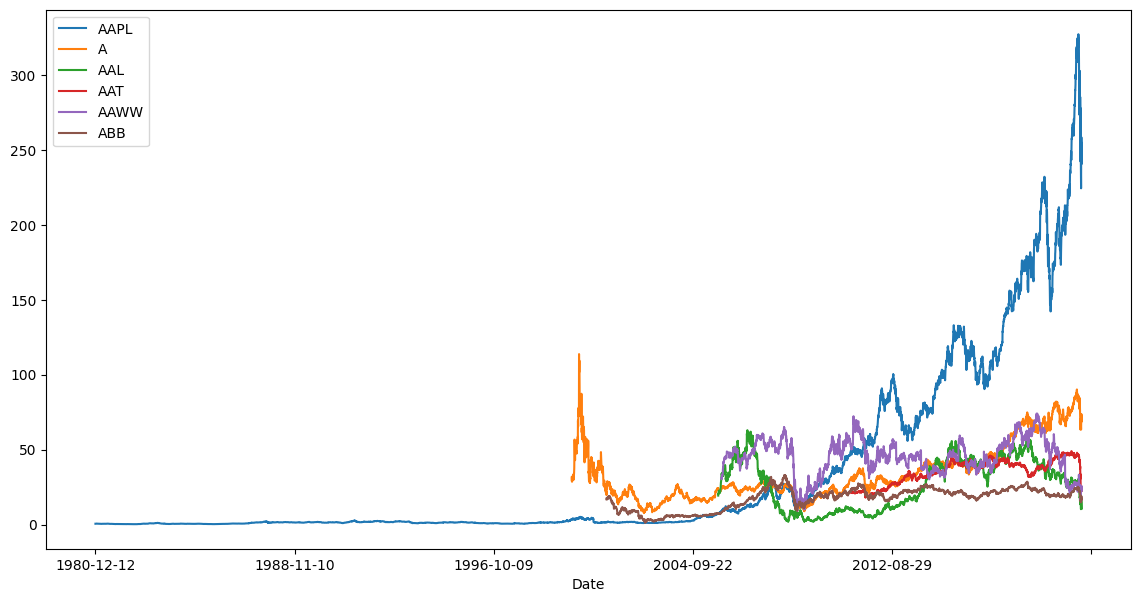

In [ ]:
full_df.plot(x='Date', y=stock_names[:6], figsize=(14, 7))

<Axes: xlabel='Date'>

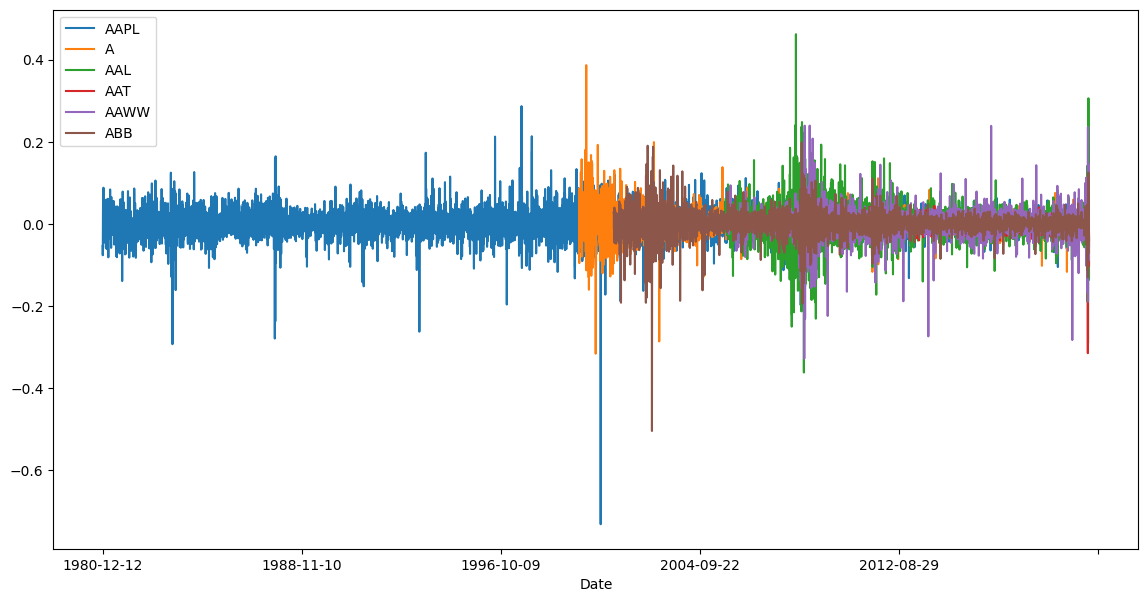

In [ ]:
# convert each column to log returns
for stock in stock_names:
    full_df[stock] = np.log(full_df[stock] / full_df[stock].shift(1))
full_df.plot(x='Date', y=stock_names[:6], figsize=(14, 7))

In [ ]:
# Trim to only the last 5000 rows
full_df = full_df.tail(5000).copy()

In [ ]:
# fill all NaN with 0
full_df.fillna(0, inplace=True)

In [ ]:
# Add shifted AAPL as column "resp" of full_df
full_df['resp'] = full_df[responder].shift(-1)
print(full_df.head())

            Date      AAPL         A  AAL  AAT  AAWW  ABB  ABBV  ABTX  ACBI  \
4909  2000-05-17 -0.041660 -0.126294  0.0  0.0   0.0  0.0   0.0   0.0   0.0   
4910  2000-05-18 -0.006184 -0.094029  0.0  0.0   0.0  0.0   0.0   0.0   0.0   
4911  2000-05-19 -0.069347 -0.063600  0.0  0.0   0.0  0.0   0.0   0.0   0.0   
4912  2000-05-22 -0.044180 -0.065915  0.0  0.0   0.0  0.0   0.0   0.0   0.0   
4913  2000-05-23 -0.046950 -0.072722  0.0  0.0   0.0  0.0   0.0   0.0   0.0   

      ...  XHR      XLNX  XVZ  XYL  YNDX    Z  ZEN  ZIV  ZTS      resp  
4909  ...  0.0 -0.024278  0.0  0.0   0.0  0.0  0.0  0.0  0.0 -0.006184  
4910  ...  0.0 -0.034619  0.0  0.0   0.0  0.0  0.0  0.0  0.0 -0.069347  
4911  ...  0.0 -0.041964  0.0  0.0   0.0  0.0  0.0  0.0  0.0 -0.044180  
4912  ...  0.0  0.058461  0.0  0.0   0.0  0.0  0.0  0.0  0.0 -0.046950  
4913  ...  0.0 -0.060504  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.021615  

[5 rows x 736 columns]


In [ ]:
# Set date as index
full_df.set_index('Date', inplace=True)

In [ ]:
train_val_split = 0.8
train_test_split = 0.1
train_df = full_df.iloc[:int(len(full_df) * train_val_split)].copy()
val_df = full_df.iloc[int(len(full_df) * train_val_split):int(len(full_df) * (train_val_split + train_test_split))].copy()
test_df = full_df.iloc[int(len(full_df) * (train_val_split + train_test_split)):].copy()

In [ ]:
# Compute train stds and normalize by them
stock_names = train_df.columns
train_stds = train_df[stock_names].std()
train_df[stock_names] = train_df[stock_names] / train_stds
val_df[stock_names] = val_df[stock_names] / train_stds
test_df[stock_names] = test_df[stock_names] / train_stds

<Axes: >

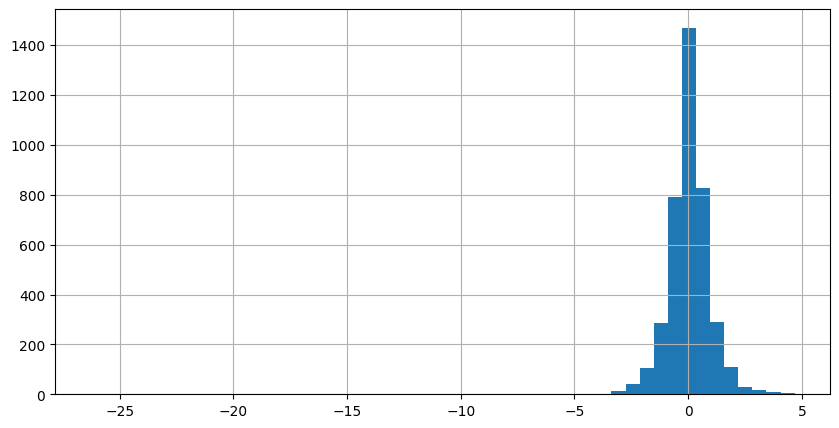

In [ ]:
train_df[responder].hist(bins=50, figsize=(10, 5))

In [ ]:
# clip all stocks to be between -5 and 5
clip_bound = 5
for stock in stock_names:
    train_df[stock] = train_df[stock].clip(-clip_bound, clip_bound)
    val_df[stock] = val_df[stock].clip(-clip_bound, clip_bound)
    test_df[stock] = test_df[stock].clip(-clip_bound, clip_bound)

<Axes: >

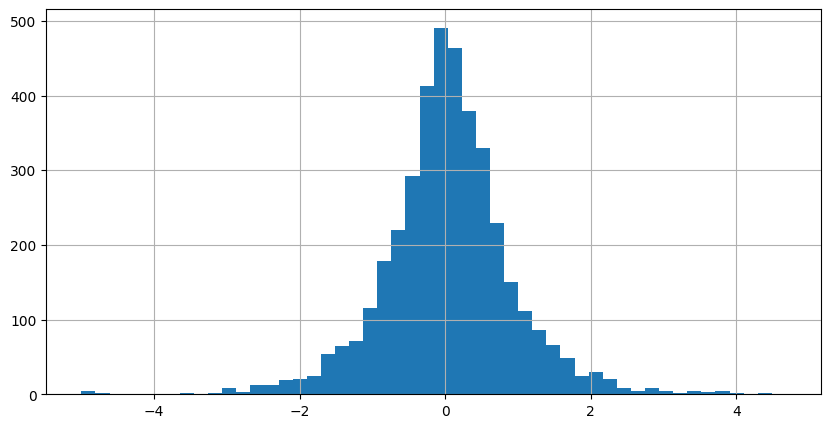

In [ ]:
train_df[responder].hist(bins=50, figsize=(10, 5))

<Axes: >

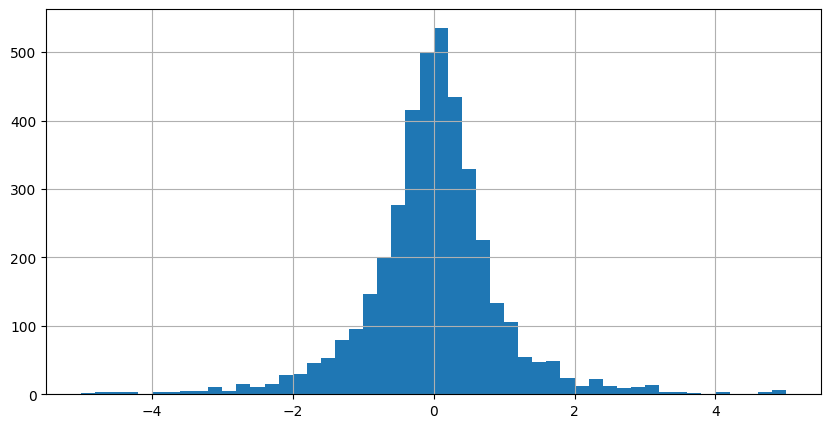

In [ ]:
train_df[predictors[0]].hist(bins=50, figsize=(10, 5))

## 5: A Simple Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def r2(y_true, y_pred):
    return 1 - mse(y_true, y_pred) / np.mean(y_true**2)

In [ ]:
# perform a simple regression from all stocks to resp

stock_names = train_df.columns.drop('resp')
X_train = train_df[stock_names].values
y_train = train_df['resp'].values
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_train)

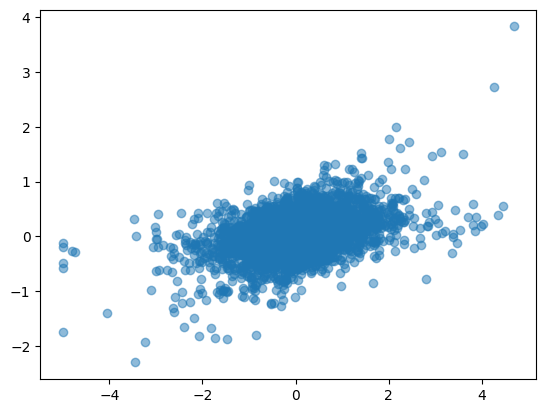

In [ ]:
# plot y_pred vs y_train
plt.scatter(y_train, y_pred, alpha=0.5)

In [ ]:
mse(y_train, y_pred)

np.float64(0.6745376104056711)

In [ ]:
r2(y_train, y_pred)

np.float64(0.172623134299128)

In [ ]:
X_val = val_df[stock_names].values
y_val = val_df['resp'].values
y_val_pred = model.predict(X_val)

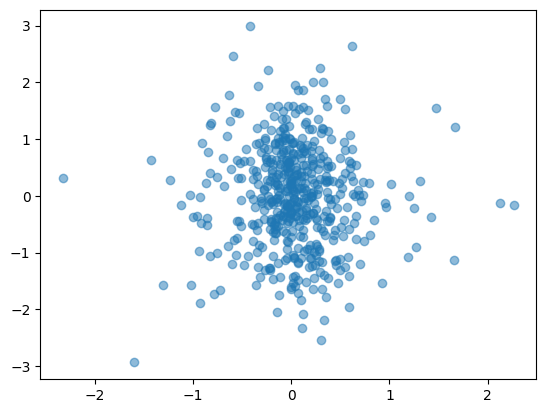

In [ ]:
# plot y_pred vs y_train
plt.scatter(y_val, y_val_pred, alpha=0.5)

In [ ]:
mse(y_val, y_val_pred)

np.float64(1.039650082585547)

In [ ]:
r2(y_val, y_val_pred)

np.float64(-3.9647771018562503)

In [ ]:
# Check the betas
betas = pd.Series(model.coef_, index=stock_names)
print(betas)

AAPL   -0.021483
A      -0.039594
AAL     0.006508
AAT     0.012934
AAWW    0.055212
          ...   
YNDX   -0.012785
Z       0.021749
ZEN    -0.006115
ZIV     0.021329
ZTS    -0.004914
Length: 734, dtype: float64


In [ ]:
# Sort betas by abs val
betas = betas.reindex(betas.abs().sort_values(ascending=False).index)
print(betas)

GOOG     0.303550
GOOGL   -0.296665
SQ       0.119698
NWE     -0.112584
RACE    -0.098135
           ...   
EFF     -0.000324
STAG    -0.000286
CHA     -0.000258
WIX      0.000160
GM       0.000010
Length: 734, dtype: float64


## 5: Regularizing the Regression

In [ ]:
# Run a regularized regression from X_train to y_train
from sklearn.linear_model import Ridge, Lasso
model = Ridge(alpha=1e4).fit(X_train, y_train)
y_pred = model.predict(X_train)

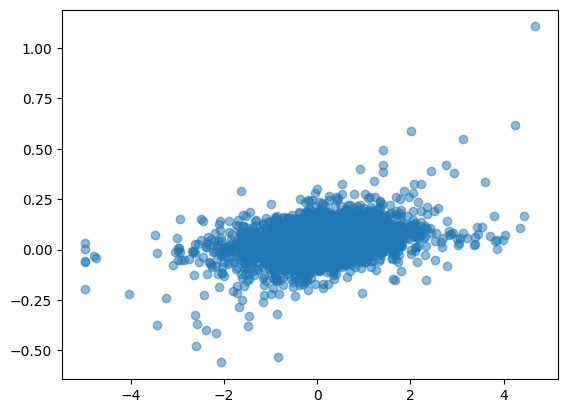

In [ ]:
plt.scatter(y_train, y_pred, alpha=0.5)

In [ ]:
r2(y_train, y_pred)

np.float64(0.052671570033119064)

In [ ]:
# Check the betas
betas = pd.Series(model.coef_, index=stock_names)
betas = betas.reindex(betas.abs().sort_values(ascending=False).index)
print(betas)

TRS     0.012955
ENS     0.011859
NWE    -0.011171
NP     -0.010713
FFIV   -0.010474
          ...   
TMHC    0.000025
MIE    -0.000017
NWS     0.000008
BLDR    0.000006
PKO     0.000002
Length: 734, dtype: float64


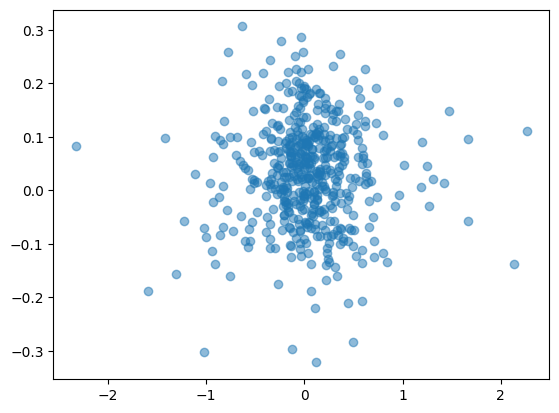

In [ ]:
y_val_pred = model.predict(X_val)
plt.scatter(y_val, y_val_pred, alpha=0.5)

In [ ]:
r2(y_val, y_val_pred)

np.float64(-0.046648132081289484)

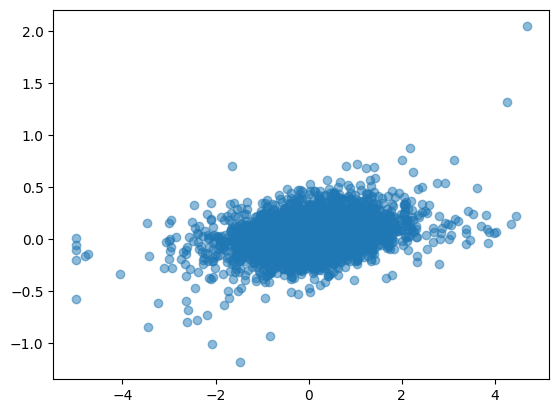

In [ ]:
# Lasso regularization
model = Lasso(alpha=1e-2).fit(X_train, y_train)
y_pred = model.predict(X_train)
plt.scatter(y_train, y_pred, alpha=0.5)

In [ ]:
r2(y_train, y_pred)

np.float64(0.08482199871054996)

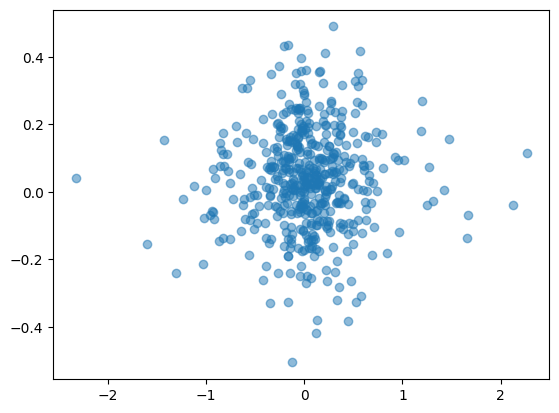

In [ ]:
y_val_pred = model.predict(X_val)
plt.scatter(y_val, y_val_pred, alpha=0.5)

In [ ]:
r2(y_val, y_val_pred)

np.float64(-0.08689498705960719)

## 6: A Rolling Regression

In [ ]:
# Function that regresses on just the past window datapoints
def window_regression(X, y, window_size=5, alpha=1e3):
    # Last window_size rows of X and y
    if len(X) < window_size:
        raise ValueError("Window size must be less than the number of samples")

    X_window = X[-window_size:].copy()
    y_window = y[-window_size:].copy()

    # model = LinearRegression()
    model = Ridge(alpha=alpha)
    model.fit(X_window, y_window)

    return model

In [ ]:
trues = []
preds = []
for i in range(len(X_train) - 1000, len(X_train)):
    model = window_regression(X_train[:i], y_train[:i], window_size=300, alpha=1e3)
    pred = model.predict(X_train[i:i+1])[0]
    trues.append(y_train[i])
    preds.append(pred)

In [ ]:
r2(np.array(trues), np.array(preds))

np.float64(-0.1229205743901749)

In [ ]:
# Function that regresses on past datapoints in a window with exponential decay
def exp_decay_regression(X, y, alpha=1e3, decay_rate=0.01, window_size=300):
    n = len(X)
    if n > window_size:
        X = X[-window_size:]
        y = y[-window_size:]
        n = window_size

    if n == 0:
        raise ValueError("No data to fit")

    # Create weights that decay exponentially
    weights = np.exp(-decay_rate * np.arange(n)[::-1])

    model = Ridge(alpha=alpha)
    model.fit(X, y, sample_weight=weights)

    return model

In [ ]:
trues = []
preds = []
for i in range(len(X_train) - 1000, len(X_train)):
    model = exp_decay_regression(X_train[:i], y_train[:i], decay_rate=0.001, alpha=1e3)
    pred = model.predict(X_train[i:i+1])[0]
    trues.append(y_train[i])
    preds.append(pred)

In [ ]:
r2(np.array(trues), np.array(preds))

np.float64(-0.10871182943152813)

## 7: Feature Engineering

In [ ]:
# Add to each stock column an EWMA version of itself
train_df_ewma = train_df.copy()
val_df_ewma = val_df.copy()
test_df_ewma = test_df.copy()
for stock in stock_names:
    train_df_ewma[f'{stock}_ewma'] = train_df[stock].ewm(alpha=0.01).mean()
    val_df_ewma[f'{stock}_ewma'] = val_df[stock].ewm(alpha=0.01).mean()
    test_df_ewma[f'{stock}_ewma'] = test_df[stock].ewm(alpha=0.01).mean()

/tmp/ipykernel_645052/1212485827.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_ewma[f'{stock}_ewma'] = train_df[stock].ewm(alpha=0.01).mean()
/tmp/ipykernel_645052/1212485827.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  val_df_ewma[f'{stock}_ewma'] = val_df[stock].ewm(alpha=0.01).mean()
/tmp/ipykernel_645052/1212485827.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

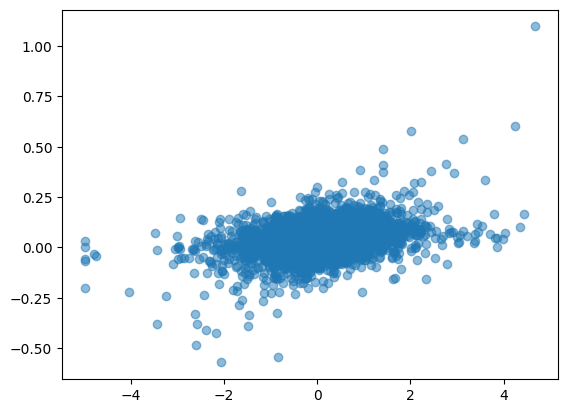

In [ ]:
X_train = train_df_ewma.drop(columns=['resp']).values
y_train = train_df_ewma['resp'].values
model = Ridge(alpha=1e4).fit(X_train, y_train)
y_pred = model.predict(X_train)
plt.scatter(y_train, y_pred, alpha=0.5)

In [ ]:
r2(y_train, y_pred)

np.float64(0.05471618929015454)

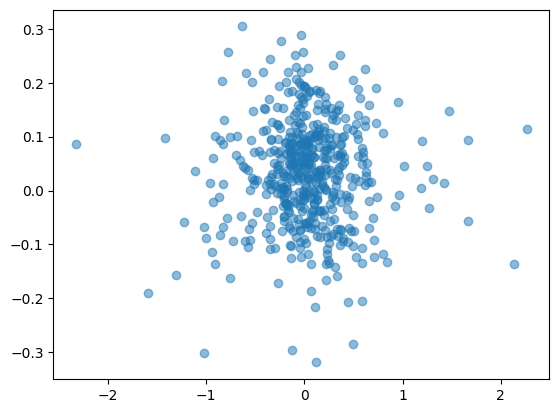

In [ ]:
X_val = val_df_ewma.drop(columns=['resp']).values
y_val = val_df_ewma['resp'].values
y_val_pred = model.predict(X_val)
plt.scatter(y_val, y_val_pred, alpha=0.5)

In [ ]:
r2(y_val, y_val_pred)

np.float64(-0.04177532667303496)

In [ ]:
trues = []
preds = []
for i in range(len(X_train) - 1000, len(X_train)):
    model = exp_decay_regression(X_train[:i], y_train[:i], decay_rate=0.01, alpha=1e4)
    pred = model.predict(X_train[i:i+1])[0]
    trues.append(y_train[i])
    preds.append(pred)

In [ ]:
r2(np.array(trues), np.array(preds))

np.float64(-0.01289157671957164)

## 8: Your Turn!